# 深度强化学习 DQN 实验

实验采用 OpenAI Gymnasium 的 Frozen Lake 环境

![frozen_lake](imgs/frozen_lake.gif)

In [1]:
import collections
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
# 训练设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## 环境

环境为一个 4x4 的网格世界，Agent 可以往上下左右四个方向移动。Agent 从起点出发，需要避开冰湖到达礼物的位置。到达终点可以获得 1 点 reward。

状态空间为：$\mathbf{S} = \{0,1,...,15\}$

动作空间为：$\mathbf{A} = \{0,1,2,3\}$

我在实验中会采用将玩家放入网格的方式模拟真实环境。我将网格的每种可能的状态使用 token 表示，然后使用嵌入层映射为高维向量。

In [3]:
# 网格世界各网格可能的状态 token
BLANK = 0
LAKE = 1
GIFT = 2
PLAYER = 3

# 网格世界地图
grid = torch.tensor([
    [BLANK, BLANK, BLANK, BLANK],
    [BLANK, LAKE, BLANK, LAKE],
    [BLANK, BLANK, BLANK, LAKE],
    [LAKE, BLANK, BLANK, GIFT]
], dtype=torch.long)

# 将玩家 token 放置在地图上
def player_on_grid(state):
    batch_size = state.size(0)
    ret = grid.unsqueeze(0).repeat(batch_size, 1, 1).to(state.device)
    indices = torch.cat((state.unsqueeze(-1) // 4, state.unsqueeze(-1) % 4), dim=-1)
    for i in range(batch_size):
        ret[i, indices[i,0], indices[i,1]] = PLAYER
    return ret

## 模型

<br>

#### 模型结构

模型采用一个嵌入层和三层卷积网络提取特征，然后通过两个线性层估计Q值。

<br>

#### 模型训练

训练过程分为两部分，首先需要从环境中获取训练样本，称为经验回放，存在经验回放缓冲器中，然后根据经验回放训练模型。其中获取经验回放需要使用 Epsilon-Greedy 算法。

<br>

**从环境中采样过程如下**：

首先使用 Epsilon-Greedy 获取动作：
$$
x \sim \text{Uniform}[0,1)
$$

$$
\begin{cases}
a = \underset{a}{\text{argmax}} Q(s,a), & x \gt \epsilon \\
a \sim \text{Uniform}(\mathbf{A}), & x \le \epsilon
\end{cases}
$$

然后将动作应用到环境，可以获取一个五元组 $(s_t,a_t,r_t,s_{t+1},\text{done})$，其中 done 是一个布尔值，表示是否为终止状态 。将这个元组存储到经验回放缓冲器，直到数量达到缓冲器的最大数量。

<br>

**训练过程如下**：

从经验回放缓冲器中随机采样一批数据，并计算 loss：
$$
\text{target} = r_t + \gamma \underset{a_{t+1}}{\text{max}} Q(s_{t+1},a_{t+1})
$$
其中 $\gamma$ 是折扣因子，

$$
\text{loss} = \text{MSELoss}(Q(s_t,a_t), \text{target})
$$

然后就可以对 loss 进行反向传播啦。

在我们的实验中存在一个终止状态（done），需要稍微改变一下 target 的算法：
$$
\text{target} = r_t + \gamma \underset{a_{t+1}}{\text{max}} Q(s_{t+1},a_{t+1}) * \text{NOT}(\text{done})
$$

<br>

**关于 $\gamma$**：

折扣因子可以避免 reward 过大，也可以让 Q 值随着时间衰减，让模型选择尽可能近的路径。

In [4]:
# 深度Q网络模型
class DQN(nn.Module):
    def __init__(self, state_size=(4, 4), action_size=4, grid_states=4, d_model=16, lr=1e-3):
        super().__init__()
        # 模型结构参数
        self.state_size = state_size
        self.action_size = action_size
        self.grid_states = grid_states
        self.d_model = d_model
        
        # 深度网络
        self.emb = nn.Embedding(self.grid_states, self.d_model)
        self.featnet = nn.Sequential(
            nn.Conv2d(d_model, 2*d_model, kernel_size=3, stride=1, padding=1),          # (4,4,16) -> (4,4,32)
            nn.ReLU(),
            nn.Conv2d(2*d_model, 4*d_model, kernel_size=3, stride=1, padding=1),        # (4,4,32) -> (4,4,64)
            nn.ReLU(),
            nn.Conv2d(4*d_model, 8*d_model, kernel_size=3, stride=1),                   # (4,4,64) -> (2,2,128)
            nn.ReLU()
        )
        self.vnet = nn.Sequential(
            nn.Linear(self._feat_size(), self._feat_size() // 8),                        # (512) -> (64)
            nn.ReLU(),
            nn.Linear(self._feat_size() // 8, self.action_size)                          # (64) -> (4)
        )
        
        # 采用均方差损失函数
        self.criterion = nn.MSELoss()

        # 迭代相关的数据
        self.iterations = 0
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
    def _feat_size(self):
        return 8 * (self.state_size[0] - 2) * (self.state_size[1] - 2) * self.d_model
        
    # 前向过程
    def forward(self, x: torch.Tensor):
        batch_size = x.size(0)
        x = player_on_grid(x)
        x = self.emb(x)
        x = x.permute(0, 3, 1, 2)
        x = self.featnet(x)
        x = x.reshape(batch_size, -1)
        x = self.vnet(x)
        return x

    # 采样
    def act(self, x: int, eps=0.1):
        # Epsilon-Greedy
        if random.random() > eps:
            with torch.no_grad():
                out = self.forward(torch.tensor([x], device=device))
                return torch.argmax(out, dim=-1).squeeze().cpu().item()
        else:
            return random.randint(0, self.action_size-1)

    # 训练
    def update(self, sample, gamma=0.9):
        state, action, reward, next_state, done = sample
        # tuple 转 tensor
        state = torch.tensor(state, device=device)
        action = torch.tensor(action, device=device)
        reward = torch.tensor(reward, device=device)
        next_state = torch.tensor(next_state, device=device)
        done = torch.tensor(done, dtype=torch.bool, device=device)
        
        # 训练主要逻辑
        self.optimizer.zero_grad()
        max_next_q = (~done) * torch.max(self.forward(next_state), dim=1)[0]
        target = reward + gamma * max_next_q
        q = self.forward(state).gather(1, action[:,None])[:,0]
        loss = self.criterion(q, target)
        loss.backward()
        self.optimizer.step()
        self.iterations += 1
        return loss.item()

#### 经验回放缓冲器

经验回放缓存器维护一个队列，用于存放在环境中采样的数据，并在训练时随机取出一定样本作为训练数据。

In [5]:
# 经验回放缓冲器
class ExpReplayBuffer:
    def __init__(self, max_len=1024):
        self.max_len = max_len
        self.buffer = collections.deque(maxlen=max_len)     # 使用队列存储
    
    def clear(self):
        self.buffer.clear()
        
    def is_full(self):
        return len(self.buffer) == self.max_len
    
    def append(self, sample):
        self.buffer.append(sample)
    
    # 随机取出一定样本用于模型训练
    def sample(self, n=256):
        zipped = random.sample(list(self.buffer), n)
        return list(zip(*zipped))

In [6]:
# 从环境中采样数据用于训练模型
def sample_from_env(env: gym.Env, net: nn.Module, buffer: ExpReplayBuffer):
    net.eval()
    obs = 0
    env_running = False
    buffer.clear()
    while not buffer.is_full():
        if not env_running:
            obs, info = env.reset()
            env_running = True
        action = net.act(obs)
        obs_next, reward, terminated, truncated, info = env.step(action)
        env_running = not (terminated or truncated)
        buffer.append((obs, action, reward, obs_next, terminated))
        obs = obs_next
    env.close()

# 训练模型
def train_model(net: nn.Module, buffer: ExpReplayBuffer, batch_size=256):
    samples = buffer.sample(batch_size)
    net.train()
    return net.update(samples, gamma=0.9)

In [18]:
# 推理，无图形化渲染，用于采集训练时的模型拟合情况
def infer(env: gym.Env, net: nn.Module):
    net.eval()
    obs, info = env.reset()
    episode_over = False
    steps = 0
    reward_cnt = 0
    while not episode_over:
        action = net.act(obs, eps=0.0)
        obs_next, reward, terminated, truncated, info = env.step(action)
        episode_over = terminated or truncated
        obs = obs_next
        steps += 1
        reward_cnt += reward
    env.close()
    return reward_cnt, steps

# 推理，图形化渲染，用于直观地观察模型的运动
def infer_human_render(env: gym.Env, net: nn.Module):
    net.eval()
    obs, info = env.reset()
    env.render()
    episode_over = False
    steps = 0
    reward_cnt = 0

    time.sleep(1)

    while not episode_over:
        action = net.act(obs, eps=0.0)
        obs_next, reward, terminated, truncated, info = env.step(action)
        env.render()

        time.sleep(0.8)

        episode_over = terminated or truncated
        obs = obs_next
        steps += 1
        reward_cnt += reward
    env.close()
    if reward_cnt == 0:
        print(f'模型未到达终点，共计{steps}步')
    else:
        print(f'模型到达终点，共计{steps}步')

In [8]:
# 保存模型
def save_model(net: DQN):
    state_dict = {
        'iterations': net.iterations,
        'model': net.state_dict(),
        'optimizer': net.optimizer.state_dict(),
    }
    save_path = f'./models/dqn_{net.iterations}.pth'
    torch.save(state_dict, save_path)
    print(f'Model saved at {save_path}.')

# 加载模型
def load_model(net: DQN, path: str):
    state_dict = torch.load(path)
    net.iterations = state_dict['iterations']
    net.load_state_dict(state_dict['model'])
    net.optimizer.load_state_dict(state_dict['optimizer'])
    print(f'Model loaded from {path}.')

In [12]:
env = gym.make('FrozenLake-v1')
net = DQN()
net = net.to(device)
buffer = ExpReplayBuffer(max_len=1024)

loss_rec = []
reward_rec = []
steps_rec = []

for i in range(1500):
    sample_from_env(env, net, buffer)
    loss = train_model(net, buffer, batch_size=256)
    reward, steps = infer(env, net)
    loss_rec.append(loss)
    reward_rec.append(reward)
    steps_rec.append(steps)
    
    # 每隔 50 iteration 打印一次
    if net.iterations % 50 == 0:
        print(f'\rIteration {net.iterations} finished with loss {loss}')

Iteration 50 finished with loss 0.0021961734164506197
Iteration 100 finished with loss 1.916979454108514e-05
Iteration 150 finished with loss 0.0032815528102219105
Iteration 200 finished with loss 0.006334337405860424
Iteration 250 finished with loss 0.0029342402704060078
Iteration 300 finished with loss 0.0050495825707912445
Iteration 350 finished with loss 0.002161448821425438
Iteration 400 finished with loss 0.00842416100203991
Iteration 450 finished with loss 0.0006848912453278899
Iteration 500 finished with loss 0.005461144261062145
Iteration 550 finished with loss 0.004677343647927046
Iteration 600 finished with loss 0.004674671217799187
Iteration 650 finished with loss 0.004319989122450352
Iteration 700 finished with loss 0.0068225194700062275
Iteration 750 finished with loss 0.003399335080757737
Iteration 800 finished with loss 0.005402174778282642
Iteration 850 finished with loss 0.004648440983146429
Iteration 900 finished with loss 0.0005027295555919409
Iteration 950 finished

In [19]:
save_model(net)

Model saved at ./models/dqn_3000.pth.


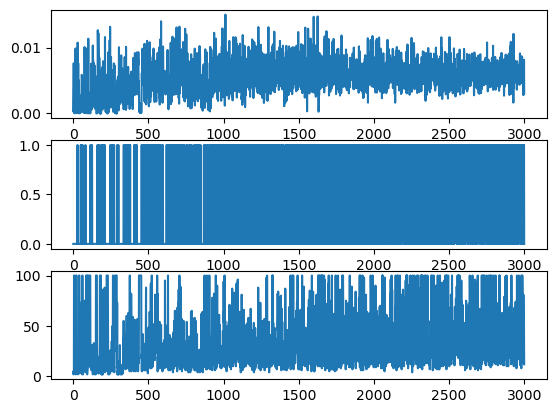

In [17]:
plt.subplot(3, 1, 1)
plt.plot(loss_rec)
plt.subplot(3, 1, 2)
plt.plot(reward_rec)
plt.subplot(3, 1, 3)
plt.plot(steps_rec)
plt.show()

In [16]:
for i in range(1500):
    sample_from_env(env, net, buffer)
    loss = train_model(net, buffer, batch_size=256)
    reward, steps = infer(env, net)
    loss_rec.append(loss)
    reward_rec.append(reward)
    steps_rec.append(steps)

    # 每隔 50 iteration 打印一次
    if net.iterations % 50 == 0:
        print(f'\rIteration {net.iterations} finished with loss {loss}')

Iteration 1550 finished with loss 0.0077525717206299305
Iteration 1600 finished with loss 0.014680886641144753
Iteration 1650 finished with loss 0.006292012985795736
Iteration 1700 finished with loss 0.006669408641755581
Iteration 1750 finished with loss 0.006795972585678101
Iteration 1800 finished with loss 0.006286188960075378
Iteration 1850 finished with loss 0.00715983472764492
Iteration 1900 finished with loss 0.003785055596381426
Iteration 1950 finished with loss 0.006883522495627403
Iteration 2000 finished with loss 0.004850997123867273
Iteration 2050 finished with loss 0.0044982098042964935
Iteration 2100 finished with loss 0.0045404378324747086
Iteration 2150 finished with loss 0.00727037014439702
Iteration 2200 finished with loss 0.005521388724446297
Iteration 2250 finished with loss 0.007231827825307846
Iteration 2300 finished with loss 0.006235888227820396
Iteration 2350 finished with loss 0.009178576990962029
Iteration 2400 finished with loss 0.005790724419057369
Iteration

In [20]:
def test():
    test_env = gym.make('FrozenLake-v1', render_mode='human')
    test_model = DQN()
    test_model = test_model.to(device)
    
    infer_human_render(test_env, test_model)
    
test()

模型未到达终点，共计100步


## 结果

很遗憾，模型一直在原地打转就是不到终点😢。虽然没有继续修改的时间了，但是理解算法的目的达到了，接下来要继续学些新东西了🤔🤔🤔